In [26]:
import numpy as np
from matplotlib import pyplot as plt

# Gillespie

In [62]:
def gillespie(events, event_consequences, Y0, t0, t_max=100):
    y, t = Y0, t0
    Y, T = np.array(Y0), [t]
    while t<t_max:
        p = propensities(t, y, events=events)
        p_rel = p/sum(p)
        tte = [time_to_event(p[i]) for i in range(len(p))]
        idx = np.random.choice(range(len(p)), p=p_rel)
        event, dt = event_consequences[idx], tte[idx]
        y = event(t, y)
        t += dt    
        T += [t]
        Y = np.vstack([Y, y])

    return T, Y

time_to_event = lambda p: (-1/p)*np.log(np.random.random())

def propensities(t, y, events):
    e_ = []
    for event in events:
        e = event(t=t, y=y)
        e_.append(e)
    return e_

In [63]:
def SIR_generator(B, f, r, a):
    def dSdt(t, y):
        return B -f*y[0]*y[1] + a*y[2]
    def dIdt(t, y):
        return f*y[0]*y[1] - r*y[1]
    def dRdt(t, y):
        return r*y[1] - a*y[2]
    
    dSIRdt = lambda t, y: np.array([dSdt(t, y), dIdt(t, y), dRdt(t, y)])
    
    return dSIRdt

def SIR_generator_v2(B, f, a, d):
    def dSdt(t, y):
        return B*(y[0]+y[1]+y[2]) -f*y[0]*y[1] - d*y[0]
    def dIdt(t, y):
        return f*y[0]*y[1] - a*y[1] - d*y[1]
    def dRdt(t, y):
        return a*y[1] - d*y[2]
    
    dSIRdt = lambda t, y: np.array([dSdt(t, y), dIdt(t, y), dRdt(t, y)])
    
    return dSIRdt

### Events

* birth
* infection
* recovery
* immunity loss

In [76]:
B, f, a, d = 0.0002, 0.0005, 0.1, 0.0002


birth_p = lambda t, y: B*(y[0]+y[1]+y[2])
infection_p = lambda t, y: f*y[0]*y[1]
recovery_p = lambda t, y: a*y[1]
death_S = lambda t, y: d*y[0]
death_I = lambda t, y: d*y[1]
death_R = lambda t, y: d*y[2]

birth_delta = lambda t, y: np.array([y[0]+1, y[1], y[2]])
infection_delta = lambda t, y: np.array([y[0]-1, y[1]+1, y[2]])
recovery_delta = lambda t, y: np.array([y[0], y[1]-1, y[2]+1])
death_S_delta = lambda t, y: np.array([y[0]-1, y[1], y[2]])
death_I_delta = lambda t, y: np.array([y[0], y[1]-1, y[2]])
death_R_delta = lambda t, y: np.array([y[0], y[1], y[2]-1])

events = [birth_p, infection_p, recovery_p, death_S, death_I, death_R]
event_consequences = [birth_delta, infection_delta, recovery_delta, 
                      death_S_delta, death_I_delta, death_R_delta]

/tmp/ipykernel_11715/1442942336.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  time_to_event = lambda p: (-1/p)*np.log(np.random.random())
/tmp/ipykernel_11715/1442942336.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  time_to_event = lambda p: (-1/p)*np.log(np.random.random())
/tmp/ipykernel_11715/1442942336.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  time_to_event = lambda p: (-1/p)*np.log(np.random.random())


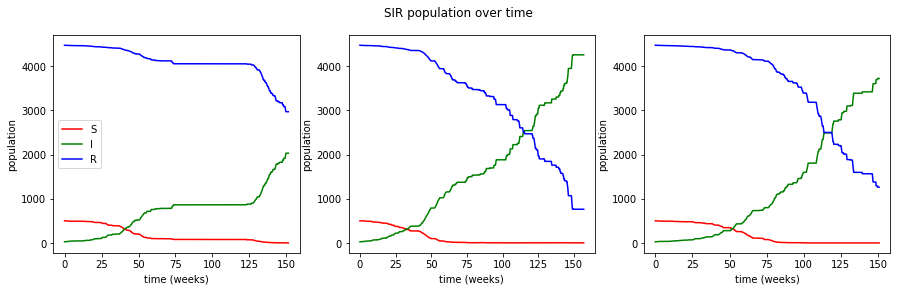

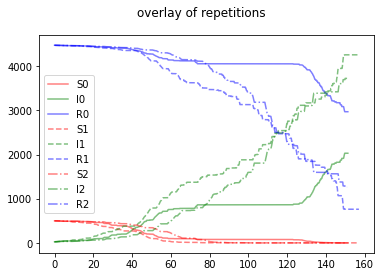

In [79]:
hyperparameters = {'B': B, 'f': f, 'a': a, 'd': d}
y0 = np.array([500, 25, 4475])

reps = 3
fig, axs = plt.subplots(1, reps)
fig2, axs2 = plt.subplots(1)
fig.set_figwidth(15)
t0=0

linestyles = ['-', '--', '-.']
colors = ['r', 'g', 'b']

for rep in range(reps):
    T, Y = gillespie(events, event_consequences, y0, t0, t_max=150)

    names = ['S', 'I', 'R']
    for i in range(Y.shape[1]):
        axs[rep].plot(T, Y[:, i], label=names[i], c=colors[i])
        axs2.plot(T, Y[:, i], label=names[i]+str(rep), c=colors[i], linestyle=linestyles[rep], alpha=0.5)
    axs[rep].set_xlabel('time (weeks)')
    axs[rep].set_ylabel('population')

fig.suptitle('SIR population over time')
axs[0].legend()

fig2.suptitle('overlay of repetitions')
axs2.legend()


# Markov

In [ ]:
T = np.array([
    [1, 0, 0, 0, 0],
    [0.5, 0, 0.5, 0, 0],
    [0, 0.5, 0, 0.5, 0],
    [0, 0, 0.5, 0, 0.5],
    [0, 0, 0, 0, 1],
])

In [31]:
def sample_markov(T, i):
    return np.random.choice(range(len(T)), p=T[i, :])

In [32]:
def trajectory(T, t0=0, max_iter=10):
    trajectory = [t0]
    for i in range(max_iter):
        trajectory += [sample_markov(T, trajectory[-1])]
    return trajectory

In [59]:
reps = 10
for rep in range(reps):
    print(trajectory(T, t0=2, max_iter=10))

[2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0]
[2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4]
[2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 2, 1, 2, 1, 2, 1, 0, 0, 0]
[2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0]
[2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [84]:
Q = T[1:-1, 1:-1]
R = np.array([
    [0.5, 0],
    [0, 0],
    [0, 0.5]
])
O = np.zeros(shape=(2, 2))
I = np.eye(2)

In [93]:
Qs = []
Q_i = np.eye(len(Q))
for i in range(10):
    Qs += [Q_i]
    Q_i = np.dot(Q_i, Q)
    print(sum(Qs))
    input()

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

[[1.  0.5 0. ]
 [0.5 1.  0.5]
 [0.  0.5 1. ]]

[[1.25 0.5  0.25]
 [0.5  1.5  0.5 ]
 [0.25 0.5  1.25]]

[[1.25 0.75 0.25]
 [0.75 1.5  0.75]
 [0.25 0.75 1.25]]

[[1.375 0.75  0.375]
 [0.75  1.75  0.75 ]
 [0.375 0.75  1.375]]

[[1.375 0.875 0.375]
 [0.875 1.75  0.875]
 [0.375 0.875 1.375]]

[[1.4375 0.875  0.4375]
 [0.875  1.875  0.875 ]
 [0.4375 0.875  1.4375]]

[[1.4375 0.9375 0.4375]
 [0.9375 1.875  0.9375]
 [0.4375 0.9375 1.4375]]

[[1.46875 0.9375  0.46875]
 [0.9375  1.9375  0.9375 ]
 [0.46875 0.9375  1.46875]]

[[1.46875 0.96875 0.46875]
 [0.96875 1.9375  0.96875]
 [0.46875 0.96875 1.46875]]



In [85]:
N = np.linalg.inv(np.eye(len(Q))-Q)
N

array([[1.5, 1. , 0.5],
       [1. , 2. , 1. ],
       [0.5, 1. , 1.5]])

In [86]:
Absorbtion_times = np.dot(N, np.ones(N.shape[1]))
Absorbtion_times

array([3., 4., 3.])

In [88]:
Absorbtion_probability = np.dot(N, R)
Absorbtion_probability

array([[0.75, 0.25],
       [0.5 , 0.5 ],
       [0.25, 0.75]])